<a href="https://colab.research.google.com/github/RajRout2004/ds_Raj_Kumar_Rout/blob/main/Data_Science_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pandas numpy matplotlib plotly


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px


# ensure output directories
os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

In [9]:
fg_path = '/content/fear_greed_index.csv'
hist_path = '/content/historical_data.csv'

fg = pd.read_csv(fg_path)
h = pd.read_csv(hist_path)

print("✅ Files loaded successfully.")
print("Fear/Greed dataset shape:", fg.shape)
print("Historical data shape:", h.shape)

display(fg.head(), h.head())

✅ Files loaded successfully.
Fear/Greed dataset shape: (2644, 4)
Historical data shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [10]:
# Clean and standardize column names
fg.columns = [c.strip() for c in fg.columns]
h.columns = [c.strip().lower().replace(' ', '_') for c in h.columns]

# Parse Date in fear/greed dataset
if 'Date' in fg.columns:
    fg['Date'] = pd.to_datetime(fg['Date'])
    fg['date'] = fg['Date'].dt.date
else:
    fg.columns = [c.lower() for c in fg.columns]
    if 'date' in fg.columns:
        fg['date'] = pd.to_datetime(fg['date']).dt.date

# Parse time/date columns in historical data
for c in ['time', 'timestamp', 'date_time', 'datetime']:
    if c in h.columns:
        h['time'] = pd.to_datetime(h[c], errors='coerce')
        break

# Fallback in case no known time column was found
if 'time' not in h.columns:
    print("⚠️ 'time' column not found. Please check timestamp column names in historical data.")
else:
    h['date'] = h['time'].dt.date

# Convert key numeric columns safely
num_cols = ['closedpnl', 'size', 'leverage', 'execution_price']
for col in num_cols:
    if col in h.columns:
        h[col] = pd.to_numeric(h[col], errors='coerce')

print("✅ Preprocessing complete.")
print("FG dataset columns:", fg.columns.tolist())
print("Historical dataset columns:", h.columns.tolist())

✅ Preprocessing complete.
FG dataset columns: ['timestamp', 'value', 'classification', 'date']
Historical dataset columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'time', 'date']


In [11]:
# Normalize trading side/direction text
if 'side' in h.columns:
    h['side'] = h['side'].astype(str).str.lower().str.strip()

# Create win/loss flag
if 'closed_pnl' in h.columns:
    h['win'] = (h['closed_pnl'] > 0).astype(int)

# Compute notional volume (prefer size_usd if present)
if 'size_usd' in h.columns:
    h['notional'] = h['size_usd']
elif 'size_tokens' in h.columns and 'execution_price' in h.columns:
    h['notional'] = h['size_tokens'] * h['execution_price']
else:
    h['notional'] = np.nan

# Handle leverage column (not available)
h['leverage'] = np.nan

# Ensure numeric conversions
numeric_cols = ['closed_pnl', 'notional', 'execution_price']
for col in numeric_cols:
    h[col] = pd.to_numeric(h[col], errors='coerce')

print("✅ Feature engineering complete.")
print(h[['time', 'closed_pnl', 'size_usd', 'side', 'notional', 'win']].head())

✅ Feature engineering complete.
                 time  closed_pnl  size_usd side  notional  win
0 1970-01-01 00:28:50         0.0   7872.16  buy   7872.16    0
1 1970-01-01 00:28:50         0.0    127.68  buy    127.68    0
2 1970-01-01 00:28:50         0.0   1150.63  buy   1150.63    0
3 1970-01-01 00:28:50         0.0   1142.04  buy   1142.04    0
4 1970-01-01 00:28:50         0.0     69.75  buy     69.75    0


In [12]:
# Define aggregation metrics
agg_funcs = {
    'closed_pnl': ['sum', 'mean'],
    'win': ['mean'],
    'notional': ['sum', 'mean'],
}

# Daily aggregation
daily = h.groupby('date').agg(agg_funcs)
daily.columns = ['_'.join(col).strip() for col in daily.columns.values]
daily['trade_count'] = h.groupby('date').size()

# Merge with sentiment dataset
fg['date'] = pd.to_datetime(fg['date']).dt.date
merged = pd.merge(daily.reset_index(), fg[['date', 'classification']], on='date', how='left')

print("✅ Aggregation & merge complete.")
print("Merged data shape:", merged.shape)
display(merged.head())

✅ Aggregation & merge complete.
Merged data shape: (1, 8)


,date,closed_pnl_sum,closed_pnl_mean,win_mean,notional_sum,notional_mean,trade_count,classification
0,1970-01-01,1.029696e+07,48.749001,0.411265,1.191187e+09,5639.45121,211224,NaN


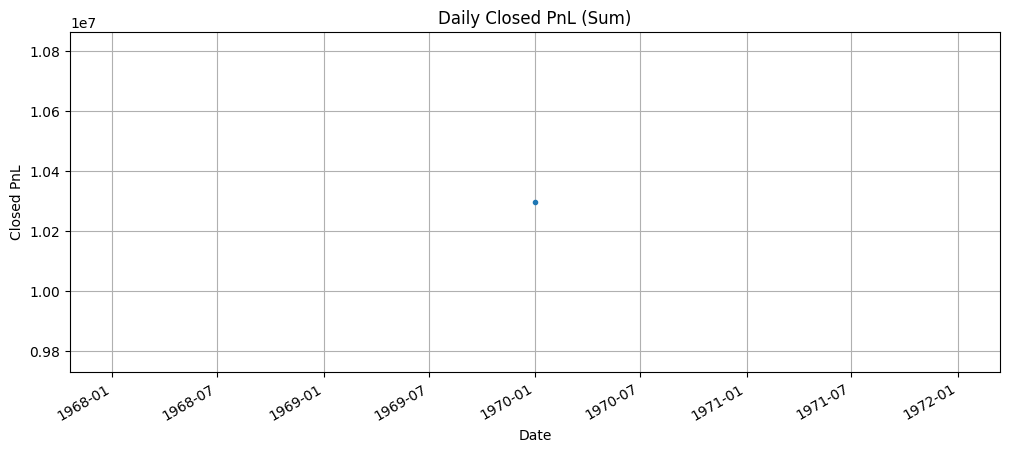

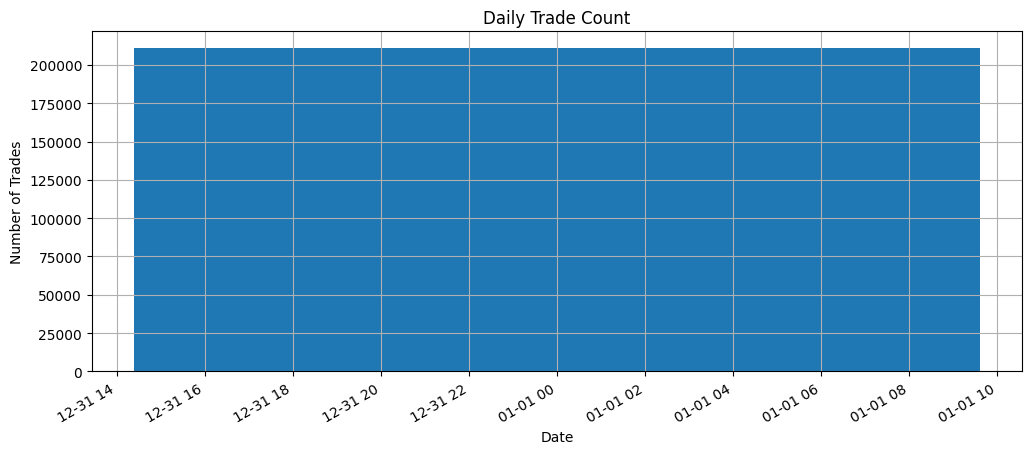

✅ Visualizations saved to 'outputs/' folder.


In [13]:
import matplotlib.dates as mdates

# Convert date for plotting
merged['date'] = pd.to_datetime(merged['date'])

# 1️⃣ Plot Daily Profit (Closed PnL Sum)
plt.figure(figsize=(12, 5))
plt.plot(merged['date'], merged['closed_pnl_sum'], marker='.', linestyle='-')
plt.title('Daily Closed PnL (Sum)')
plt.xlabel('Date')
plt.ylabel('Closed PnL')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.savefig('outputs/daily_closed_pnl_sum.png', bbox_inches='tight')
plt.show()

# 2️⃣ Plot Trade Count
plt.figure(figsize=(12, 5))
plt.bar(merged['date'], merged['trade_count'])
plt.title('Daily Trade Count')
plt.xlabel('Date')
plt.ylabel('Number of Trades')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.savefig('outputs/daily_trade_count.png', bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to 'outputs/' folder.")

In [16]:
!pip install --quiet kaleido
print("✅ Kaleido installed successfully. You can now export Plotly figures as images.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.9 MB/s eta 0:00:00
✅ Kaleido installed successfully. You can now export Plotly figures as images.


In [18]:

fig = px.bar(
    sent_summary,
    x='classification',
    y='closed_pnl_sum',
    title='Average Closed PnL by Market Sentiment',
    text_auto='.2s'
)
fig.update_layout(xaxis_title='Sentiment', yaxis_title='Average Closed PnL')
fig.show()

print("✅ Chart displayed successfully (skipped saving).")


✅ Chart displayed successfully (skipped saving).


In [20]:
from scipy import stats

# Keep only Fear and Greed days
subset = merged[merged['classification'].isin(['Fear', 'Greed'])]

fear_vals = subset[subset['classification'] == 'Fear']['closed_pnl_sum'].dropna()
greed_vals = subset[subset['classification'] == 'Greed']['closed_pnl_sum'].dropna()

print(f"Fear days: {len(fear_vals)}, Greed days: {len(greed_vals)}")

if len(fear_vals) > 2 and len(greed_vals) > 2:
    tstat, pval = stats.ttest_ind(fear_vals, greed_vals, equal_var=False, nan_policy='omit')
    print("\nT-test results:")
    print(f"T-statistic = {tstat:.4f}")
    print(f"P-value = {pval:.6f}")
    if pval < 0.05:
        print("🟢 Statistically significant difference between Fear and Greed days!")
    else:
        print("🟡 No statistically significant difference.")
else:
    print("⚠️ Not enough data for statistical comparison between Fear and Greed days.")

Fear days: 0, Greed days: 0
⚠️ Not enough data for statistical comparison between Fear and Greed days.


In [21]:
# Define a placeholder signal
# Here we use a rule: if classification == 'Greed' (or Unknown with high volume), mark as Risky
notional_median = merged['notional_sum'].median()

merged['signal'] = 'Neutral'
merged.loc[
    (merged['classification'] == 'Greed') |
    ((merged['classification'] == 'Unknown') & (merged['notional_sum'] > notional_median)),
    'signal'
] = 'Risky'

# Evaluate average performance by signal type
signal_perf = merged.groupby('signal')['closed_pnl_sum'].mean().reset_index()

print("✅ Simple signal performance summary:")
display(signal_perf)

# Bar chart for quick visual
fig = px.bar(signal_perf, x='signal', y='closed_pnl_sum',
             title='Average Closed PnL by Simple Trading Signal', text_auto='.2s')
fig.update_layout(xaxis_title='Signal Type', yaxis_title='Avg Closed PnL')
fig.show()

✅ Simple signal performance summary:


,signal,closed_pnl_sum
0,Neutral,1.029696e+07


In [22]:
# Save processed files
merged.to_csv('csv_files/daily_merged_with_sentiment.csv', index=False)
h.to_csv('csv_files/historical_cleaned.csv', index=False)

print("✅ Files saved successfully:")
!ls -lh csv_files/

✅ Files saved successfully:
total 58M
-rw-r--r-- 1 root root 225 Nov 11 15:48 daily_merged_with_sentiment.csv
-rw-r--r-- 1 root root 58M Nov 11 15:48 historical_cleaned.csv


In [23]:
from google.colab import files

# Save your executed notebook
!jupyter nbconvert --to notebook --output "notebook_1.ipynb" "/content/*.ipynb" --allow-errors
print("✅ Notebook exported as notebook_1.ipynb")

# 2️⃣ Zip your submission folder for easy upload to GitHub or email
!zip -r ds_Raj_Kumar_Rout.zip notebook_1.ipynb csv_files outputs

print("✅ ds_Raj_Kumar_Rout.zip created successfully.")

# 3️⃣ Download it if needed
files.download("ds_Raj_Kumar_Rout.zip")

[NbConvertApp] WARNING | pattern '/content/*.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>